# Credit Card Fraud Detection using Anomaly Detection | Part 2c (Tuning)

**Problem**: Predict whether a credit card transaction is fraudulent or not based on its details. Extract the patterns that hint towards fraud by modeling the past transactions such that all frauds are detected and false positives are minimised.

**Evaluation**: Recall, PR-AUC, f1, Precision @t will be used for fine-tuning and evaluation using available labels

**Potential Solution Framework**: Since we have enough labeled data, we are using the fully-supervised anomaly detection setting (learning data structure from labels) using below two approaches. Note: One this common though, we would be trying to learn the underlying "normal" distribution & draw threshold boundary to weed out anomalies

**-----b. "End-to-end fully-supervised"-----**
    - pass whatever (normal or anomolous or both) that available training-fold labeled data is
    - then use those models to check and validate on whatever that remaining available valid-fold data is
    - Pros/Cons:
      i. We could use gridsearchcv directly
      ii. OCSVM would not perform well on such mixed data**

**Existing intuitions on algorithms (based on performance on 2D datasets)** -
Source (https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py):
- IF and LOF are good when we have multimodal data. LOF is better when modes have different desities (local aspect of LOF)
- OCSVM is sensitive to outliers and doesn't generally perform well for OD (but good for ND when training data is uncontaminated), but depending on values of hyperparamters it could still give useful results
- EllipticEnvelope assumes Gaussian distribution and thus learns ellipse. Not good for multimodal data but robust to outliers

**Useful material and references**
- https://escholarship.org/uc/item/1f03f6hb#main
- https://www.hindawi.com/journals/complexity/2019/2686378/
- https://imada.sdu.dk/~zimek/InvitedTalks/TUVienna-2016-05-18-outlier-evaluation.pdf
- https://www.gta.ufrj.br/~alvarenga/files/CPE826/Ahmed2016-Survey.pdf
 

## 1. Importing Libraries

In [2]:
#Importing necessary data science libraries
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; 
%matplotlib inline
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import pickle
import scipy.stats as stats

#Importing data processing and prep libraries
from sklearn.preprocessing import StandardScaler, RobustScaler   #RobustScaler robust to outliers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  #for hyperparameter tuning

#Importing machine learning algo libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Importing evaluation focussed libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, average_precision_score

#Other useful libraries
#!pip install missingno   
import missingno as missviz   #Custom library for missing value inspections
from sklearn.manifold import TSNE   #For visualising high dimensional data

## 2. Getting relevant data

In [3]:
#Importing
with open("ADS_a.pkl", "rb") as f:
    X_in, y_in, X_in_out, y_in_out, X_cols, y_cols = pickle.load(f)
    
#Basic details
print("Details of inliers data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_in.shape, J=sum(y_in)))
print("Details of inliers_outliers data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_in_out.shape, J=sum(y_in_out)))

Details of inliers data - shape of predictor matrix is (227452, 30) and # ones in target series is 0
Details of inliers_outliers data - shape of predictor matrix is (57355, 30) and # ones in target series is 492


## 3. Drafting model

**3.1 Building basline model (default settings)**

In [124]:
# Creating a dictionary of models (anomaly detectors in "novel" detection mode)
seed=123
models = {
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM(random_state=seed)}

In [146]:
#Creating a class of anomaly detection model
class Basic_Anomaly_Detectors:
    """
    Accepts models' dictionary that should run on data
    """
    def __init__(self, models):
        self.models = models
       
    def provide_data(self, X_in, X_in_out, y_in, y_in_out): 
        #Training will have inliers only; Test will have a separate subset of inliers & outliers  
        self.X_train = X_in
        self.y_train = y_in
        self.X_test = X_in_out
        self.y_test = y_in_out
        
        #Print basic details
        print("Details of train data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=self.X_train.shape, J=sum(self.y_train)))
        print("Details of test data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=self.X_test.shape, J=sum(self.y_test)))
    
    def fit_score_predict(self):
        y_scores_dict={}
        y_pred_dict={}
        results=[] 
        for model_name, model in self.models.items():
            print("------------------Fitting {M} algorithm---------------".format(M=model_name))
            
            %time model.fit(self.X_train)
            y_scores = model.decision_function(self.X_test)
            y_pred = model.predict(self.X_test)
                 
            #The algos predicts {1,-1} for {normal, anomalous} case, whereas original y has {0,1}
            y_pred[y_pred==1]=0
            y_pred[y_pred==-1]=1

            #Evaluation (using Recall, F1, PR-AUC)
            Recall = recall_score(self.y_test,y_pred)
            F1= f1_score(self.y_test,y_pred)
            PR_AUC = average_precision_score(self.y_test,y_scores)

            #Collating outputs
            y_scores_dict[model_name]=y_scores
            y_pred_dict[model_name]=y_pred
            results.append([model_name, Recall, F1, PR_AUC])
        
        self.y_scores_dict=y_scores_dict
        self.y_pred_dict=y_pred_dict
        self.results_df = pd.DataFrame(results, columns=["model_name", "Recall", "F1", "PR_AUC"])
        
    def evaluate_plot(self):
        for model_name, model in self.models.items():
            print("------------------Evaluating/Plotting {M} algorithm------------------".format(M=model_name))
            results_df_model = self.results_df[self.results_df["model_name"]==model_name]

            #Printing results
            print('Classifiation report on test data:', '\n', classification_report(self.y_test,self.y_pred_dict[model_name]))  
            print('Recall: {}'.format(results_df_model["Recall"].values))
            print('F1: {}'.format(results_df_model["F1"].values))
            print("PR-AUC: {}".format(results_df_model["PR_AUC"].values))    

            #Plotting results
            cm=confusion_matrix(self.y_test,self.y_pred_dict[model_name])
            P, R, _ = precision_recall_curve(self.y_test,self.y_scores_dict[model_name])

            fig, axs = plt.subplots(1,2, figsize=(16,5))
            axs=axs.flatten()

            sns.heatmap(cm, annot=True, ax=axs[0], fmt=".1f")
            axs[0].set_xlabel("Predicted"); axs[0].xaxis.set_ticklabels(['normal', 'anomaly'])
            axs[0].set_ylabel("Actual"); axs[0].yaxis.set_ticklabels(['normal', 'anomaly'])
            axs[0].set_title("Confusion Matrix")

            axs[1].plot(P,R)
            axs[1].set_xlabel('Recall')
            axs[1].set_ylabel('Precision')
            axs[1].set_title("PR-curve")

            plt.show()
            fig.tight_layout()

Details of train data - shape of predictor matrix is (11373, 30) and # ones in target series is 0
Details of test data - shape of predictor matrix is (2868, 30) and # ones in target series is 25
------------------Fitting IF algorithm---------------
CPU times: user 583 ms, sys: 41.2 ms, total: 624 ms
Wall time: 636 ms
------------------Fitting LOF algorithm---------------
CPU times: user 5.84 s, sys: 94.2 ms, total: 5.94 s
Wall time: 6.09 s
------------------Fitting OCSVM algorithm---------------
CPU times: user 6.06 s, sys: 142 ms, total: 6.2 s
Wall time: 6.36 s
------------------Evaluating/Plotting IF algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      2843
           1       0.07      0.96      0.13        25

   micro avg       0.89      0.89      0.89      2868
   macro avg       0.54      0.93      0.54      2868
weighted avg       0.99      0.89      0.94      2868

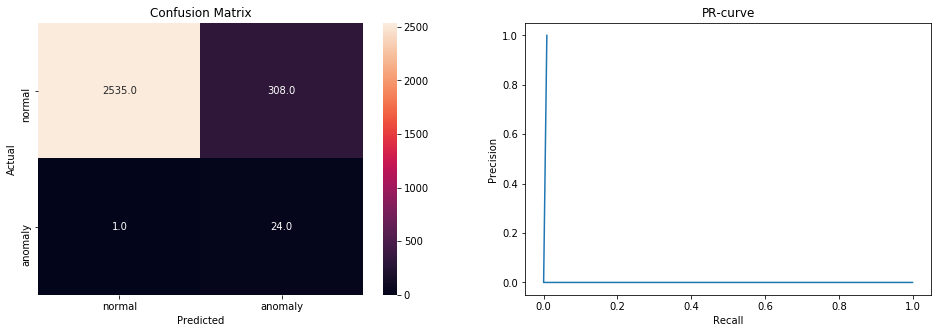

------------------Evaluating/Plotting LOF algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.94      2843
           1       0.07      0.92      0.13        25

   micro avg       0.90      0.90      0.90      2868
   macro avg       0.54      0.91      0.54      2868
weighted avg       0.99      0.90      0.94      2868

Recall: [0.92]
F1: [0.13372093]
PR-AUC: [0.00459315]


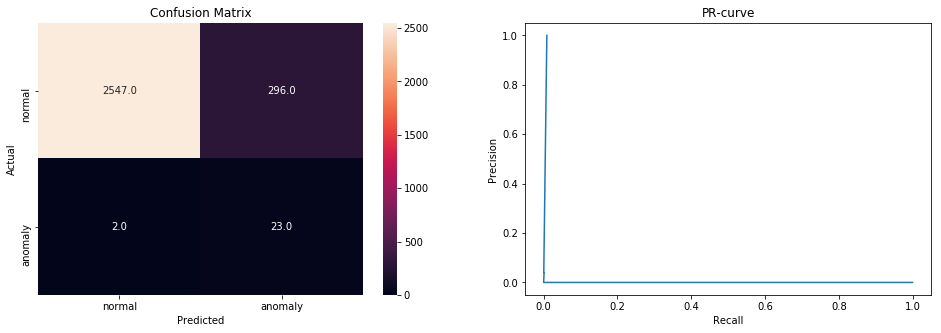

------------------Evaluating/Plotting OCSVM algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.66      2843
           1       0.02      1.00      0.03        25

   micro avg       0.50      0.50      0.50      2868
   macro avg       0.51      0.75      0.35      2868
weighted avg       0.99      0.50      0.66      2868

Recall: [1.]
F1: [0.03378378]
PR-AUC: [0.00458315]


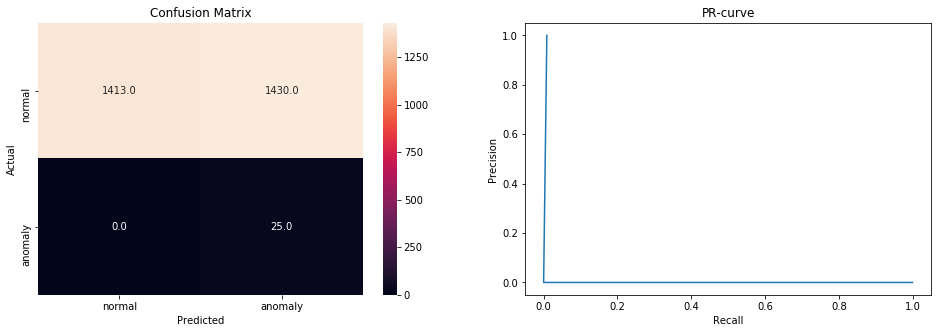

In [148]:
#Instantiating and running our "Basic_Anomaly_Detectors"
BAD=Basic_Anomaly_Detectors(models)
BAD.provide_data(X_in_small, X_in_out_small, y_in_small, y_in_out_small)
BAD.fit_score_predict()
BAD.evaluate_plot()

In [150]:
#Result summary of "Basic_Anomaly_Detectors"
BAD.results_df

,model_name,Recall,F1,PR_AUC
0,IF,0.96,0.134454,0.004571
1,LOF,0.92,0.133721,0.004593
2,OCSVM,1.00,0.033784,0.004583


## 4. Hyperparameter tuning and model selection

**4.1 Splitting data into "small" and "big" parts; and combining "small" data into one X, y**
- Note: We'll train and tune using the whole data in Google colab with GPUs

In [7]:
#Splitting inlier and (inlier+outlier) into "small" and "big" parts to expedite training and tuning
seed=123
small_frac=0.05
X_in_big, X_in_small, y_in_big, y_in_small = train_test_split(X_in, y_in, test_size=small_frac, random_state=seed)
X_in_out_big, X_in_out_small, y_in_out_big, y_in_out_small = train_test_split(X_in_out, y_in_out, test_size=small_frac, stratify=np.array(y_in_out), random_state=seed)

In [ ]:
#Making one combined data of inliers + (inliers+outliers) to be passed to next steps
X_comb_small = np.concatenate((X_in_small, X_in_out_small), axis=0)
y_comb_small = np.concatenate((y_in_small, y_in_out_small), axis=0)

**4.2 Creating custom CV-folds class to control how training & tuning happens**
- We need to pass CV-folds to the hyperparamter tuning algos (RSCV, GSCV) such that: 
    1. training happens only on inliers
    2. validation happens on (inliers + outliers) 

In [ ]:
#Creating custom k-folds class of this combined data for tuning further such that:
class InlierOutlier_CustomCVFolds:
    def __init__(self, n_splits, random_state):
        self.n_splits=n_splits
        self.random_state = random_state
        
    def custom_split(self, X, y, groups=None):
        #Splitting X, y in KFold manner s.t. we have inliers for training and (inliers + all outliers) for validation
        for io_t_id, io_v_id in StratifiedKFold(n_splits=self.n_splits, random_state=self.random_state).split(X, y):
            y_df = pd.DataFrame(y, columns=[y_cols])

            #Segregating training_ids into inlier_training_ids and outlier_training_ids 
            temp=pd.DataFrame(y_comb_small_df.ix[io_t_id,"Class"]==1)
            i_t_id = np.array(temp.index[temp["Class"]==False])
            o_t_id = np.array(temp.index[temp["Class"]==True])

            #Manipulating such that t_id is just inliers, whereas v_id is inliers + outliers
            t_id = i_t_id
            v_id = np.concatenate((o_t_id, io_v_id))

            yield t_id, v_id 
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

**4.3 Creating dictionary of "intialized" models and a custom scoring function for CVs**
- Note: that we need this custom scoring function for CV steps, since output of anomaly detection model prediction is {-1,1}, so in order to use f1_score appropriately, we'll need to make this transformation in predicted values of y, else it behaves weirdly

In [ ]:
#Creating a dictionary of "initialized" defualt models
models={
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM(random_state=seed)}

#Creating a custom scoring function (which takes in 3 arguments - model, X, y under RSCV & GSCV)
def my_f1_score(model, X, y):
    y_pred=model.predict(X)
    return f1_score(y, np.where(y_pred==1,0,1))

**4.4 Training and tuning models**
    1. Using RandomizedSearchCV first (which is also fast) to determine an interesting hyperparameter space
    2. Then, we'll use GridSearchCV later to narrow down to the specifics (space where performance seems good)

**4.4.1 RandomizedSearchCV (and validation curve)**

In [ ]:
#Creating a dictionary of models' hyperparameters for RSCV
model_hp_dist_rscv={
    "IF": {"contamination": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)], "max_samples": [10**-1*np.random.uniform(1,10) for i in np.arange(1,100)], "n_estimators": [np.random.randint(2, 1000) for i in np.arange(1,100)]},
    "LOF": {"contamination": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)], "n_neighbors": [np.random.randint(2, 1000) for i in np.arange(1,100)]},
    "OCSVM": {"nu": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)] , "kernel": ["linear", "rbf", "poly"], "gamma": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)]}}

results_rscv=[]
for model_name in models.keys():
    print("-----Running RandomizedSearchCV for {M}-----".format(M=model_name))
    model=models[model_name]
    hp=model_hp_dist_rscv[model_name]
    cv = InlierOutlier_CustomCVFolds(3, random_state=seed).custom_split(X_comb_small, y_comb_small)
    RSCV=RandomizedSearchCV(model, hp, cv=cv, n_iter=30, random_state=seed, scoring=my_f1_score, n_jobs=-1, verbose=10)
    %time RSCV.fit(X_comb_small, y_comb_small)
    results_rscv.append([model_name, RSCV.best_params_, RSCV.best_score_, RSCV.cv_results_])
    
results_rscv_df=pd.DataFrame(results_rscv, columns=["model_name", "best_hp", "best_score", "CV_results"])

In [ ]:
#Plotting validation curves:
results_model_df_dict={}
print("----------------------\n Validation Curves \n----------------------", )
for i, model_name in enumerate(models):
    print("<", model_name, ">")
    print("-Best score", "\n",results_rscv_df[results_rscv_df["model_name"]==model_name]["best_score"][i])
    print("-Best hps", "\n",results_rscv_df[results_rscv_df["model_name"]==model_name]["best_hp"][i])
    results_model_df = pd.DataFrame(results_rscv_df[results_rscv_df["model_name"]==model_name]['CV_results'].values[0])    
    hp_cols_model = [col for col in results_model_df.columns if ("param_" in col)]
    
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs=axs.flatten()
    for i, hp_col in enumerate(hp_cols_model):
        results_model_df.sort_values(hp_col).groupby(hp_col)["mean_train_score"].mean().plot(ax=axs[i], color='red')
        results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].mean().plot(ax=axs[i], color='green')
        
    plt.show()

**4.4.2 GridSearchCV**

In [151]:
model_hp_grid_gscv={
    "IF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "max_samples": list(range(10,300,60)), "n_estimators": [10,50,100,200,500]},
    "LOF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "n_neighbors": [5,10,20,50,100]},
    "OCSVM": {"nu": [0.0001, 0.001, 0.0025, 0.005, 0.01], "kernel": ["linear", "rbf", "poly"], "gamma": np.power(10.0, range(-3,2))}}